In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import os
import glob
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
import cv2
gait_dir = '/Users/iwoods/Documents/GitHub/gait/'
this_dir = os.getcwd()
os.chdir(gait_dir)
import gaitFunctions
import combineClips
import plotClip
os.chdir(this_dir)
def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'

# colors for legs
first_pair_color = '#b45eff' # lavender
first_pair_color_alt = '#661f99' # purple
second_pair_color = '#006f2a' # green
second_pair_color_alt = '#02db55' # light green
third_pair_color = '#ffd500' # yellow
third_pair_color_alt = '#fa9805' # orange
rear_leg_color = '#00b6eb'# light blue
rear_leg_color_alt = '#0010eb' # dark blue

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# Option 1: Select the folders to include in the analysis ... (or see below)

In [3]:
# navigate to directory that contains the data
main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/videos_disulfiram/'
os.chdir(main_dir)
# list directories within this directory
dirs = []
for dirname, dirnames, filenames in os.walk('.'):
    # print path to all subdirectories first.
    for subdirname in dirnames:
        folder = os.path.join(dirname, subdirname).split('/')[1]
        if folder not in dirs:
            dirs.append(folder)
dirs = np.sort(np.unique(np.array(dirs)))
dirs = [x for x in dirs if 'disulfiram' in x.lower()] # change to babies or adults or ramazzottius or disulfiram
folders_in_analysis = gaitFunctions.selectMultipleFromList(dirs) 


Choose from this list (separate by commas if multiple choices): 
1: Disulfiram 12Jan24 Inverted
2: Disulfiram 13Dec23 Inverted
3: Disulfiram 16Dec22 Inverted
4: Disulfiram 8Dec22 Inverted
5: comparing disulfiram
6: xDisulfiram 21Nov22 dissectingscope
7: zDisulfiram 16Nov23 TTclass StudentVids
8: zDisulfiram 21April23 weakdrug
9: select ALL

Which number(s) do you want? 1,2,3,4
You chose: Disulfiram 12Jan24 Inverted and Disulfiram 13Dec23 Inverted and Disulfiram 16Dec22 Inverted and Disulfiram 8Dec22 Inverted


# Option 2: Manually select the folders

In [3]:
main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/'
base_dir = '/Users/iwoods/Library/CloudStorage/OneDrive-IthacaCollege/2024_movement_disorder_paper/'
folders_in_analysis = [base_dir + 'videos_wild/ramazzottius_14Sep23',
                       base_dir + 'videos_wild/ramazzottius_21Sep23',
                       base_dir + 'videos_exemplaris/iw_11Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_18Jan24_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_21Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_9Nov23_exemplaris_inverted'
]

# Load the data from the selected folders

In [4]:
### in each folder, look for a 'combined' excel file and load (or append) it to a dataframe
# if there is no 'combined' excel file, run combineClips and then load the file
os.chdir(main_dir)

path_summaries_df = pd.DataFrame()
step_timing_df = pd.DataFrame()
step_summaries_df = pd.DataFrame()
gait_summaries_df = pd.DataFrame()
gait_styles_speeds_df = pd.DataFrame()

def appendDF(original,new):
    if len(original) == 0:
        original = new
    else:
        new = pd.concat([original, new])
    return new

for folder in folders_in_analysis:
    os.chdir(folder)
    combined_files = sorted(glob.glob('*combined*xlsx'))
    if len(combined_files) == 0:
        print('Combining .xlsx files in ' + folder)
        pdf, stcdf, sdf, gdf, gssdf = combineClips.main(True)
    elif len(combined_files) == 1:
        excel_file = combined_files[0]
        print('Found ' + combined_files[0])
        
        # read in data from this excel file
        pdf = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
        stdf = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
        sdf = pd.read_excel(excel_file, sheet_name='step_summaries', index_col=None)
        gdf = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
        gssdf = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
        
        # append to existing dataframe
        path_summaries_df = appendDF(path_summaries_df, pdf)
        step_timing_df = appendDF(step_timing_df, stdf)
        step_summaries_df = appendDF(step_summaries_df, sdf)
        gait_summaries_df = appendDF(gait_summaries_df, gdf)
        gait_styles_speeds_df = appendDF(gait_styles_speeds_df, gssdf)
    else:
        print('Too many "combined" files in ' + folder)
    os.chdir(main_dir)
path_summaries_df.head(5)

Found Disulfiram 12Jan24 Inverted_combined.xlsx
Found Disulfiram 13Dec23 Inverted_combined.xlsx
Found Disulfiram 16Dec22 Inverted_combined.xlsx
Found Disulfiram 8Dec22 Inverted_combined.xlsx


,Identifier,treatment,individual,date,Scale (pixels in 1mm),Body Size (mm^2),Body Length (mm),Body Width (mm),Body Width/Length Ratio,Duration analyzed (sec),...,Percentage of time cruising,Speed (mm/sec cruising),Speed (body lengths / sec cruising),Total bearing change (deg),Bearing change (deg) / sec,Bearing change (deg) / sec cruising,Number of stops,Stops / sec,Number of turns,Turns / sec
0,iw_12jan_tardigrade01_control,control,tardigrade01,12jan,956.03,0.012985,0.238598,0.073853,0.309530,99.5535,...,87.693710,0.044907,0.188211,2377.436000,23.880989,15.608393,13,0.130583,8,0.080359
1,iw_12jan_tardigrade01_disulfiram,disulfiram,tardigrade01,12jan,956.03,0.011568,0.211995,0.075648,0.356837,167.7272,...,45.709124,0.031727,0.149659,6954.287733,41.461896,22.670600,61,0.363686,44,0.262331
2,iw_12jan_tardigrade02_control,control,tardigrade02,12jan,956.03,0.014216,0.247831,0.077100,0.311102,115.2875,...,83.013914,0.042615,0.171954,2330.605200,20.215593,16.363241,18,0.156131,9,0.078066
3,iw_12jan_tardigrade02_disulfiram,disulfiram,tardigrade02,12jan,956.03,0.014620,0.250047,0.079605,0.318362,107.3940,...,72.262980,0.039543,0.158144,2297.907267,21.396980,15.860098,22,0.204853,7,0.065181
4,iw_12jan_tardigrade03_control,control,tardigrade03,12jan,956.03,0.011513,0.225085,0.068042,0.302294,110.8947,...,96.098226,0.052538,0.233415,1536.464000,13.855162,10.619561,4,0.036070,4,0.036070


# Exploring the data

In [7]:
df = step_summaries_df

In [8]:
df.count()
# df.describe()

Identifier                                           44
treatment                                            44
individual                                           44
Stance duration (lateral legs)                       44
Swing duration (lateral legs)                        44
Gait cycle (lateral legs)                            44
Duty factor (lateral legs)                           44
mm per step (lateral legs)                           44
bodylength per step (lateral legs)                   44
Stance duration (rear legs)                          44
Swing duration (rear legs)                           44
Gait cycle (rear legs)                               44
Duty factor (rear legs)                              44
mm per step (rear legs)                              44
bodylength per step (rear legs)                      44
Metachronal lag (lateral legs)                       42
Metachronal lag (normalized, lateral legs)           42
Metachronal lag Left-Right Ratio                

In [9]:
# change 'treatment' to category datatype, and see how many we have (there should be 2)
df['treatment'] = df['treatment'].astype('category')
df.describe(include='category')

,treatment
count,44
unique,2
top,control
freq,24


In [10]:
# dummy variable for treatment
control = 'control'
df['Condition'] = np.where(df['treatment'] == control, 0, 1)
df.head(3)

,Identifier,treatment,individual,Stance duration (lateral legs),Swing duration (lateral legs),Gait cycle (lateral legs),Duty factor (lateral legs),mm per step (lateral legs),bodylength per step (lateral legs),Stance duration (rear legs),...,Metachronal lag (lateral legs),"Metachronal lag (normalized, lateral legs)",Metachronal lag Left-Right Ratio,Anterior swing offsets (lateral legs),"Anterior swing offsets (normalized, lateral legs)",Opposite swing offsets (lateral legs),"Opposite swing offsets (normalized, lateral legs)",Opposite swing offsets (rear legs),"Opposite swing offsets (normalized, rear legs)",Condition
0,iw_12jan_tardigrade01_control,control,tardigrade01,0.809456,0.251526,1.060982,0.757096,0.037117,0.155593,0.463111,...,0.763647,0.719755,0.506614,0.384500,0.351333,0.500613,0.459903,0.381640,0.511608,0
1,iw_12jan_tardigrade01_disulfiram,disulfiram,tardigrade01,1.094946,0.335081,1.430027,0.756224,0.037428,0.176039,0.549176,...,1.882500,1.328122,0.040780,0.850111,0.605835,0.671667,0.474669,0.501154,0.512099,1
2,iw_12jan_tardigrade02_control,control,tardigrade02,0.983225,0.271788,1.255013,0.778564,0.041833,0.169110,0.628057,...,1.472167,1.174047,0.628001,0.705558,0.561529,0.604786,0.486358,0.496966,0.485765,0


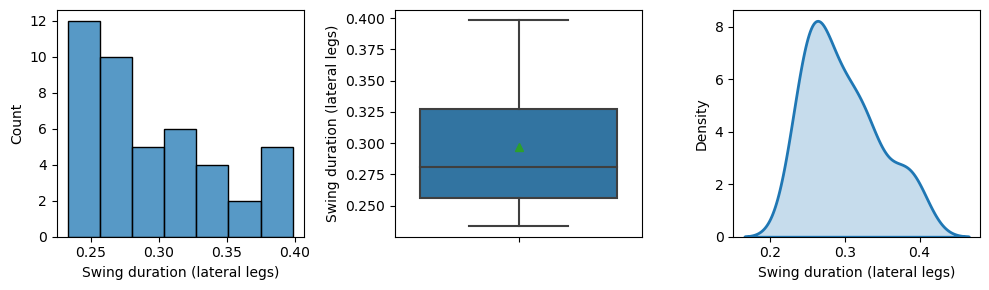

In [11]:
# looking at ALL data for a specified column
col = 'Swing duration (lateral legs)'
f,[a1,a2,a3] = plt.subplots(1,3,figsize=(10,3))
a1=sns.histplot(ax=a1, x=df[col])
a2=sns.boxplot(ax=a2, y=df[col], showmeans=True)
a3=sns.kdeplot(ax=a3, x=df[col], fill=True, linewidth=2);
plt.tight_layout()
plt.show()

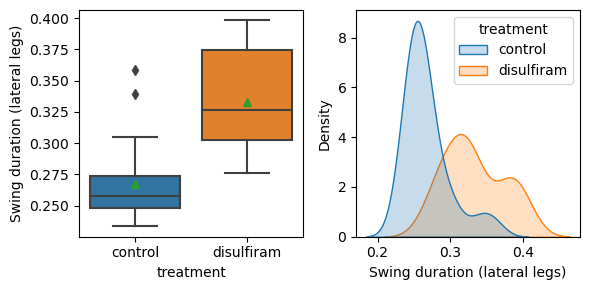

In [12]:
# comparing control vs. treatment for a specified column (col)
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
sns.boxplot(ax=a1, x=df['treatment'], y=df[col], showmeans=True)
sns.kdeplot(ax=a2, x=col, hue='treatment', data=df, fill=True)
plt.tight_layout()
plt.show()

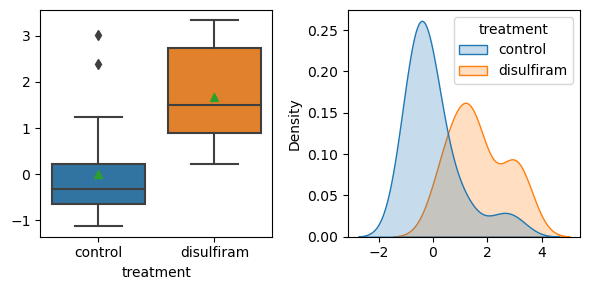

In [13]:
# trying ZSCORES
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))

conditions = df['Condition'].values
zscores = np.zeros(len(df[col].values))
control_data = df[df['Condition']==0][col].values
exp_data = df[df['Condition']==1][col].values
control_mean = np.mean(control_data)
control_std = np.std(control_data)
exp_std = np.std(exp_data)

for i, val in enumerate(df[col].values):
    if conditions[i] == 0: # control
        zscores[i] = (val-control_mean) / control_std
    elif conditions[i] == 1: # exp
        zscores[i] = (val-control_mean) / exp_std

sns.boxplot(ax=a1, x=df['treatment'], y=zscores, showmeans=True)
sns.kdeplot(ax=a2, x=zscores, hue='treatment', data=df, fill=True)
plt.tight_layout()
plt.show()

In [14]:
# T-test using fancy statsmodels
control_data = df[df['Condition']==0][col].values
exp_data = df[df['Condition']==1][col].values
levene=stats.levene(control_data, exp_data)
if levene.pvalue < 0.1:
    var = 'unequal'
    print('unequal variance')
else:
    var = 'pooled'
model = sms.CompareMeans.from_data(control_data, exp_data)
print(model.summary(usevar=var))

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     -0.0654      0.011     -6.100      0.000      -0.087      -0.044


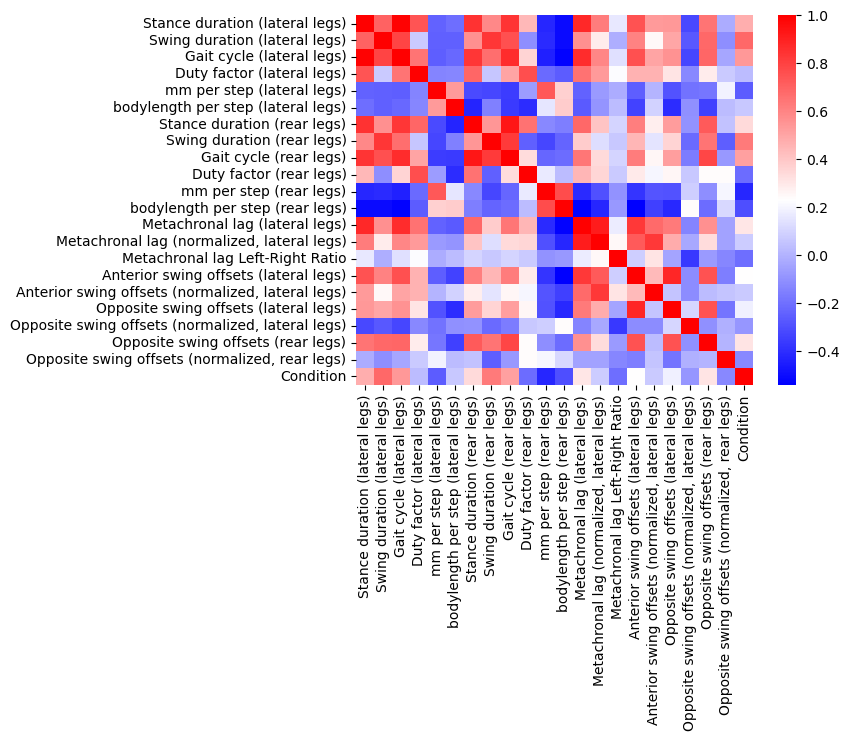

In [15]:
# looking for correlations within the dataset
corrmat = df.corr(numeric_only=True)
sns.heatmap(corrmat,cmap='bwr')
plt.show()

In [16]:
# Try a linear regression with X as 'Condition' and Y as a column of interest
import statsmodels.api as sm
Y = df[col]
X = df['Condition']
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Swing duration (lateral legs)   R-squared:                       0.470
Model:                                       OLS   Adj. R-squared:                  0.457
Method:                            Least Squares   F-statistic:                     37.21
Date:                           Fri, 26 Jan 2024   Prob (F-statistic):           2.85e-07
Time:                                   19:14:15   Log-Likelihood:                 85.584
No. Observations:                             44   AIC:                            -167.2
Df Residuals:                                 42   BIC:                            -163.6
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2673      0.007     36.984      0.000       0.253       0.282
Condition      0.0654      0.011      6.100      0.000       0.044       0.087
==============================================================================
Omnibus:                        5.566   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.028
Skew:                           0.828   Prob(JB):                       0.0809
Kurtosis:                       3.023   Cond. No.                         2.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

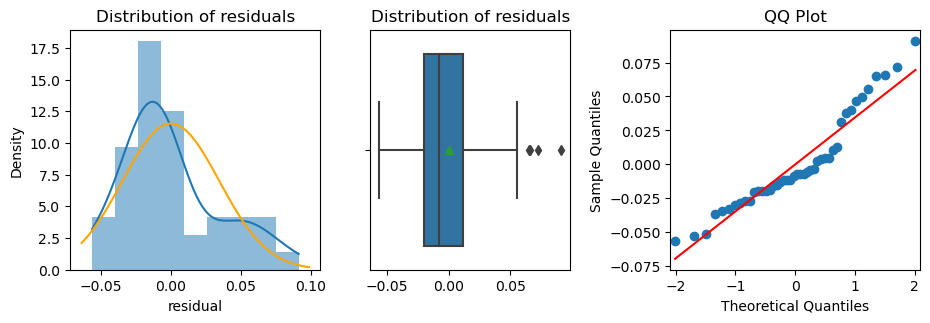

In [17]:
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_axes([0.1,0.1,0.25,0.8])
ax2 = fig.add_axes([0.4,0.1,0.2,0.8])
ax3 = fig.add_axes([0.7,0.1,0.25,0.8])

mu, std = stats.norm.fit(model_result.resid)

# plot the residuals
sns.histplot(ax=ax1, x=model_result.resid, stat="density", linewidth=0, kde=True)
ax1.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = ax1.get_xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(ax=ax1, x=x, y=p, color="orange")

sns.boxplot(ax=ax2, x=model_result.resid, showmeans=True)
ax2.set(title="Distribution of residuals")

sm.qqplot(model_result.resid, line='s',ax=ax3)
ax3.set(title="QQ Plot")

plt.show()

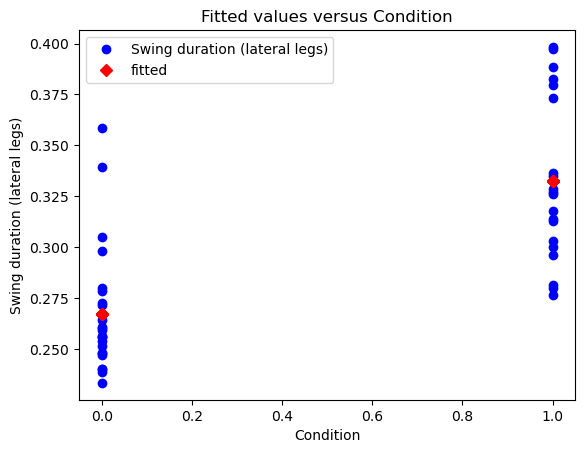

In [18]:
sm.graphics.plot_fit(model_result,1, vlines=False)
plt.show()

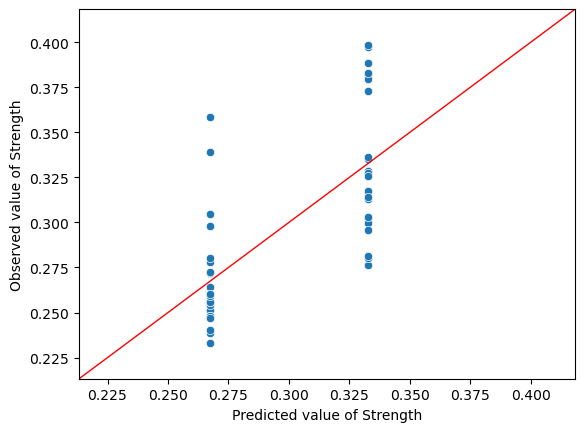

In [19]:
Y_max = Y.max()+0.02
Y_min = Y.min()-0.02

ax = sns.scatterplot(x=model_result.fittedvalues, y=Y)
ax.set(ylim=(Y_min, Y_max))
ax.set(xlim=(Y_min, Y_max))
ax.set_xlabel("Predicted value of Strength")
ax.set_ylabel("Observed value of Strength")

X_ref = Y_ref = np.linspace(Y_min, Y_max, 100)
plt.plot(X_ref, Y_ref, color='red', linewidth=1)
plt.show()

# multiple linear regression

In [20]:
# could do, for example, condition and length vs. speed
# or condition and speed vs. swing duration
Y = df['Swing duration (lateral legs)']
X = df[['Condition','bodylength per step (lateral legs)']] 
X = sm.add_constant(X)
X.head(3)

,const,Condition,bodylength per step (lateral legs)
0,1.0,0,0.155593
1,1.0,1,0.176039
2,1.0,0,0.169110


In [21]:
model = sm.OLS(Y, X)
model_res = model.fit()
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Swing duration (lateral legs)   R-squared:                       0.553
Model:                                       OLS   Adj. R-squared:                  0.532
Method:                            Least Squares   F-statistic:                     25.40
Date:                           Fri, 26 Jan 2024   Prob (F-statistic):           6.67e-08
Time:                                   19:16:12   Log-Likelihood:                 89.360
No. Observations:                             44   AIC:                            -172.7
Df Residuals:                                 41   BIC:                            -167.4
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  0.4063      0.051      8.028      0.000       0.304       0.509
Condition                              0.0671      0.010      6.725      0.000       0.047       0.087
bodylength per step (lateral legs)    -0.8610      0.311     -2.771      0.008      -1.489      -0.233
==============================================================================
Omnibus:                        6.683   Durbin-Watson:                   2.196
Prob(Omnibus):                  0.035   Jarque-Bera (JB):                5.464
Skew:                           0.789   Prob(JB):                       0.0651
Kurtosis:                       3.700   Cond. No.                         71.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

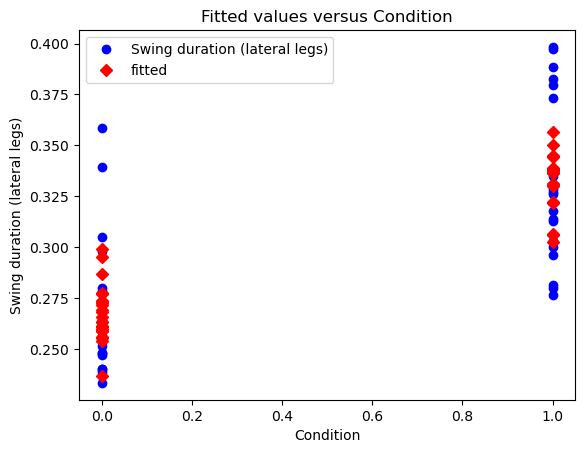

In [22]:
sm.graphics.plot_fit(model_res,1, vlines=False)
plt.show()

# Functions for pairwise boxplots and stats

T-test p-val 0.012


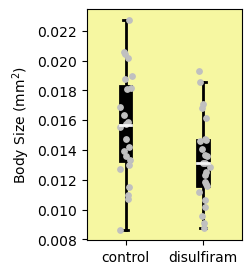

In [102]:
def compBoxPlot(ax,df,col): 
 
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
    
    # make boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, showfliers=False)
    bp = gaitFunctions.formatBoxPlots(bp, ['black'], ['whitesmoke'], ['dimgrey'])
    
    # add scatter over the boxplot
    a = 1 # alpha
    sc = 'silver' # [ 0.76, 0.86, 0.85 ] # 'k' # color
    sz = 15 # marker size
    ji = 0.05 # jitter around midline
    for i, group in enumerate(groupnames):   
        xScatter = np.random.normal(i+1, ji, size=len(data_to_plot[i]))
        ax.scatter(xScatter, data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)
    
    return ax, data_to_plot

def pairwiseStats(pair,testtype='pair'):
    
    if testtype == 'kw':
        kruskal = stats.kruskal(pair[0],pair[1])
        test='Kruskal-Wallis'
        pval = kruskal.pvalue
        return pval,test

    # shapiro ... test for normal distribution!
    # the shapiro statistic tends to be 'high' (close to 1) ... 
    # when samples are drawn from a normal distribution 
    normal_distribution = True
    shapiro_threshold = 0.9
    for d in pair:
        shapiro = stats.shapiro(d)
        if shapiro.statistic < shapiro_threshold:
            normal_distribution = False
            # print('Shapiro stat',np.round(shapiro.statistic,2),'p-val',np.round(shapiro.pvalue,2))

    # levene ... test for equal variance!
    # The value of the statistic tends to be high when there is a large difference in variances.
    # if p value is 'small' the variances of the groups may not be equal
    equal_variance = True
    levene = stats.levene(pair[0],pair[1])
    # print('Levene stat',np.round(levene.statistic,2),'p-val',np.round(levene.pvalue,2))
    levene_threshold = 0.1
    if levene.pvalue < levene_threshold:
        equal_variance = False
        
    if normal_distribution and equal_variance: # run a t-test
        test = 'T-test'
        ttest = stats.ttest_ind(pair[0],pair[1])
        pval = ttest.pvalue
    else:
        test = 'Mann-Whitney U'
        mwu = stats.mannwhitneyu(pair[0],pair[1])
        pval = mwu.pvalue
    
    return pval, test

def correctMultipleTests(ps,method): # method is 'bonferroni' or 'benjamini-hochberg' or 'benjamini-yekutieli'
    if method == 'bonferroni':
        adj_ps = [x*len(ps) for x in ps]
    elif method == 'benjamini-hochberg' or method == 'bh':
        adj_ps = [x for x in stats.false_discovery_control(ps)]
    elif method == 'benjamini-yekutieli' or method == 'by':
        adj_ps = [x for x in stats.false_discovery_control(ps, method='by')]
    else:
        print('No pvalue adjustment')
        adj_ps = ps
    return adj_ps

def facecolorPval(ax,pval):
    
    if pval < 0.001:
        fc = '#f7b0b0' # pinkish
    elif pval < 0.01:
        fc = '#fcca74' # orange-ish
    elif pval < 0.05:
        fc = '#f6f7a1' # yellow-ish
    else:
        fc = 'white'
    
    ax.set_facecolor(fc)

    return ax

f,ax = plt.subplots(1,1,figsize=(2,3))
ax, data_to_plot = compBoxPlot(ax,path_summaries_df,'Body Size (mm^2)')
pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
print(test, 'p-val', np.round(pval,3))
plt.show()


# Path Tracking

In [153]:
print(list(path_summaries_df.columns))
path_cols =[
#     'Body Size (mm^2)', 
    'Body Length (mm)',
#     'Body Width (mm)', 
    'Body Width/Length Ratio', 
#     'Duration analyzed (sec)',
#     'Distance traveled (mm)', 
    'Percentage of time cruising',
#     'Speed (mm/sec)',
#     'Speed (body lengths / sec)', 
    'Speed (mm/sec cruising)', 
    'Speed (body lengths / sec cruising)',
#     'Total bearing change (deg)', 
#     'Bearing change (deg) / sec',
    'Bearing change (deg) / sec cruising', 
#     'Number of stops', 
    'Stops / sec',
#     'Number of turns', 
#     'Turns / sec'
]
print(len(path_cols))

['Identifier', 'treatment', 'individual', 'date', 'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)', 'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)', 'Distance traveled (mm)', 'Speed (mm/sec)', 'Speed (body lengths / sec)', 'Percentage of time cruising', 'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)', 'Total bearing change (deg)', 'Bearing change (deg) / sec', 'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec', 'Number of turns', 'Turns / sec', 'Condition']
7


['T-test', 'T-test', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'Mann-Whitney U']
[0.004, 0.008, 0.0, 0.001, 0.005, 0.007, 0.004, 0.084]
[0.021, 0.026, 0.0, 0.006, 0.021, 0.026, 0.021, 0.227]


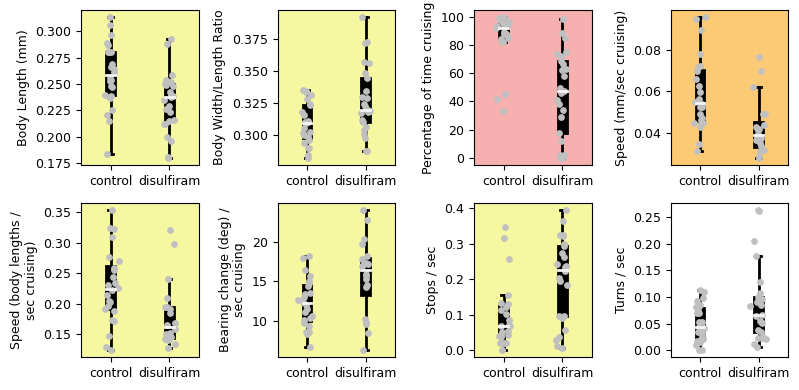

In [110]:
def boxArray(maxcols,df,to_compare):

    if len(to_compare) % maxcols == 0:
        numrows = int(len(to_compare) / maxcols)
        cushion = 0
    else:
        numrows = int(len(to_compare) / maxcols) + 1
        cushion = maxcols - (len(to_compare) % maxcols)
    rows,cols = [numrows,maxcols]
    f,axes = plt.subplots(rows,cols,figsize = (8,2*numrows))
    axes_list = axes.reshape(1,len(to_compare)+cushion)[0]
    pvals = []
    tests = []
    for i, col in enumerate(to_compare):
        axes_list[i], data_to_plot = compBoxPlot(axes_list[i], df, col)
        pval,test = pairwiseStats(data_to_plot)# ,'kw')
        pvals.append(pval)
        tests.append(test)
        axes_list[i].yaxis.label.set_size(tick_fontsize)
        axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    for i in np.arange(cushion):
        axes_list[-(i+1)].set_axis_off()
    print(tests)
    print([np.round(x,3) for x in pvals])

    # adjust p-values for multiple hypothesis testing
    adj_ps = correctMultipleTests(pvals,'by') # 'bonferroni' or 'bh' or 'by'
    print([np.round(x,3) for x in adj_ps])

    # recolor axes based on p-vals
    if cushion != 0:
        axes_list = axes_list[:-cushion]
    for i, ax in enumerate(axes_list):
        ax = facecolorPval(ax,adj_ps[i])

    plt.tight_layout()
    plt.show()

boxArray(4,path_summaries_df,path_cols)

# Step kinematics

In [100]:
# print(step_summaries_df.columns)
step_cols = [
    'Stance duration (lateral legs)', 
    'Swing duration (lateral legs)',
#     'Gait cycle (lateral legs)', 
#     'Duty factor (lateral legs)',
#     'mm per step (lateral legs)', 
    'bodylength per step (lateral legs)',
    'Stance duration (rear legs)', 
    'Swing duration (rear legs)',
#     'Gait cycle (rear legs)', 
#     'Duty factor (rear legs)',
#     'mm per step (rear legs)', 
    'bodylength per step (rear legs)',
#     'Metachronal lag (lateral legs)',
#     'Metachronal lag (normalized, lateral legs)',
    'Metachronal lag Left-Right Ratio',
#     'Anterior swing offsets (lateral legs)',
    'Anterior swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (lateral legs)',
    'Opposite swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (rear legs)',
    'Opposite swing offsets (normalized, rear legs)']
print(len(step_cols))

10


['T-test', 'Mann-Whitney U', 'T-test', 'T-test', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U']
[0.001, 0.0, 0.69, 0.024, 0.0, 0.024, 0.142, 0.786, 0.316, 0.972]
[0.011, 0.0, 1.0, 0.143, 0.0, 0.143, 0.693, 1.0, 1.0, 1.0]


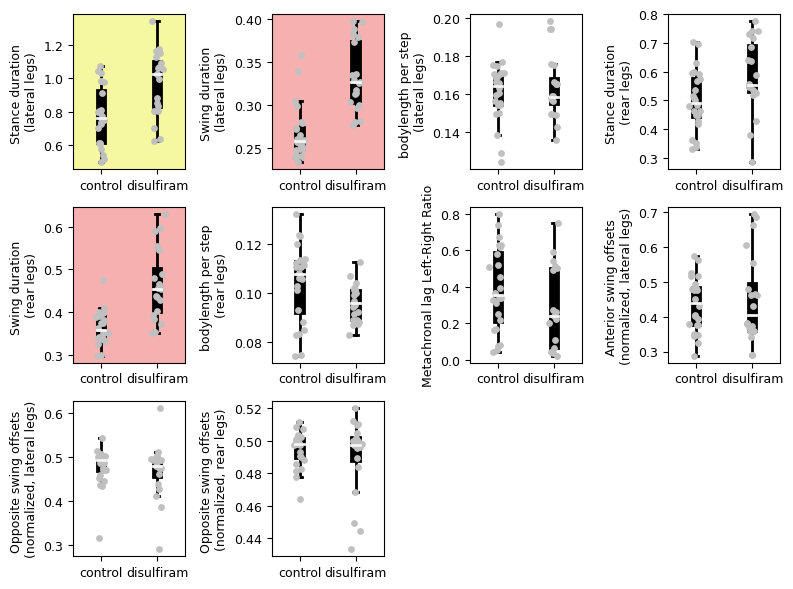

In [111]:
boxArray(4,step_summaries_df,step_cols)

# Speed and swing time
For Disulfiram (or comparison where one group is slower),
<br> the swing duration (and stance duration) could be longer 
<br> just because the speed is slower.
<br>To test, would need to normalize for speed.
<br> One way = plot speed vs. avg swing or stance length ... still a diff at same speeds?

# Gait styles

In [92]:
# print(gait_summaries_df.columns)
gait_cols = [
#     '% stand (lateral legs)',
#     '% pentapod (lateral legs)',
#     '% tetrapod canonical (lateral legs)',
#     '% tetrapod gallop (lateral legs)', 
#     '% tetrapod other (lateral legs)',
#     '% tetrapod total (lateral legs)', 
#     '% tripod canonical (lateral legs)',
#     '% tripod other (lateral legs)', 
#     '% tripod total (lateral legs',
#     '% other (lateral legs)',
#     '% stand (rear legs)', 
#     '% hop (rear legs)',
#     '% step (rear legs)',
    'Tetrapod Coordination Strength',
#     'Tetrapod Bout Speed (bodylength / s)',
    'Tripod Coordination Strength',
#     'Tripod Bout Speed (bodylength / s)'
]
print(len(gait_cols))

2


['Mann-Whitney U', 'Mann-Whitney U']
[0.147, 0.487]
[0.442, 0.731]


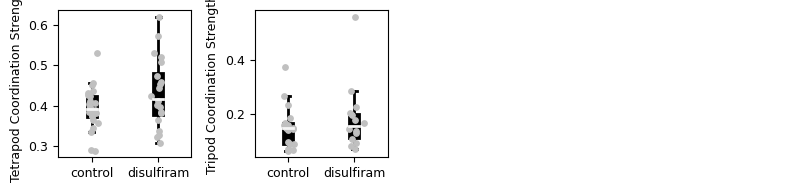

In [112]:
boxArray(4,gait_summaries_df,gait_cols)


Body Length (mm) -0.1514240300629461 0.0395175549033498
Body Width/Length Ratio 0.07978537213646383 0.055474607549839225
Percentage of time cruising -0.9189463743398395 0.0002184919618042738
Speed (mm/sec cruising) -0.4756517366726841 0.009341112338363827
Speed (body lengths / sec cruising) -0.34105132377303493 0.0408896102700137
Bearing change (deg) / sec cruising 0.3457206438031977 0.055474607549839225
Stops / sec 1.071417622323882 0.0395175549033498
Stance duration (lateral legs) 0.3257712108320134 0.01473079219102672
Swing duration (lateral legs) 0.31571541095565864 0.00019461342835148625
bodylength per step (lateral legs) 0.017617371187550603 1.0
Stance duration (rear legs) 0.21877104713758436 0.13759675296663768
Swing duration (rear legs) 0.34883278618917246 0.00047091947819138035
bodylength per step (rear legs) -0.11480789533662304 0.13759675296663768
Metachronal lag Left-Right Ratio -0.41892599905044237 0.7086348180478463
Anterior swing offsets (normalized, lateral legs) 0.048

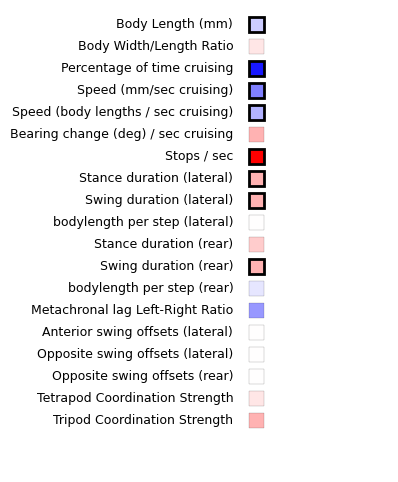

In [329]:
# function for Z-scores, Z-score plots, and combining dataframes
def pairZscore(data,conditions):
    # data is a vector of numbers for control and experimental treatments
    # conditions is a vector of 0 and 1 (for pairs), where
    # 'control' is assumed to be 0
    control_data = data[np.where(conditions==0)]
    exp_data = data[np.where(conditions==1)]
    control_mean = np.nanmean(control_data)
    control_std = np.nanstd(control_data)
    exp_std = np.nanstd(exp_data)
    zscores = np.zeros(len(data))
    for i, d in enumerate(data):
        if conditions[i] == 0: # control!
            zscores[i] = (d-control_mean)/control_std
        elif conditions[i] == 1:
            zscores[i] = (d-control_mean)/exp_std
    return zscores
    
def mergeDataframes(dflist,col='Identifier'):
    df = dflist[0].copy()
    for i in np.arange(len(dflist[:-1])):
        df = df.merge(dflist[i+1],on=col)
    return df

def getLevelColor(cmap,level):
    colormap = mpl.colormaps[cmap]
    level_boundaries = np.linspace(-0.95,0.95,20)
    cmap_levels = np.linspace(0,1,21)
    
    for i, boundary in enumerate(level_boundaries):
        if level <= boundary:
            return colormap(cmap_levels[i])
        
    return colormap(cmap_levels[-1])

def ratioPlot(ax, dflist, colslist, control='control', cmap='bwr'):
    '''
    Parameters
    
    dflist: a list of dataframes, usually path_summaries_df, step_summaries_df, gait_summaries_df
         or pdf, sdf, gdf
    colslist: a list of lists of columns within these dataframes
    '''

    # find total number of comparisons
    total_cols = np.sum(np.array([len(x) for x in colslist]))
    
    # make empty containers for zscore_ratios and pvals and labels
    log2ratios = np.zeros(total_cols)
    pvals = np.zeros(total_cols)
    labels = np.empty(total_cols, dtype='object')
    idx = 0 # index for these containers
    
    # go through dflist and colslist
    for i,columns in enumerate(colslist):
        
        df = dflist[i].copy()

        # set control to 0 and experimental to 1
        df['Condition'] = np.where(df['treatment'] == control, 0, 1)
        conditions = df['Condition'].values

        for column in columns:
            
            data = df[column].values
            
            control_data = data[np.where(conditions==0)]
            exp_data = data[np.where(conditions==1)]
            
            # remove nan (no data)
            control_data = control_data[~np.isnan(control_data)]
            exp_data = exp_data[~np.isnan(exp_data)]
    
            # get pval for this column            
            pval, test = pairwiseStats([control_data, exp_data])
#             print(column, pval, test) # testing
            pvals[idx] = pval
    
            # get label for this column
            labels[idx] = column
            
            # get log2(experiment/control) ratio for this column
            log2ratios[idx] = np.log2(np.mean(exp_data)/np.mean(control_data))          
    
            idx += 1

    # correct pvals for multiple comparisons
    adj_pvals = correctMultipleTests(pvals,'by')
    
    ytext = 0.2 # level for text above the lower edge of each square

    ylevel = len(labels) + 1

    # go through data
    for i, label in enumerate(labels):
    
        # plot a square, with color scaled to log2_ratio
        square_color = getLevelColor(cmap, log2ratios[i])
        
        # plot a thick border if significant
        if adj_pvals[i] < 0.05:
            linewidth = 2
        else:
            linewidth = 0.1
        
        square = patches.Rectangle((0.1, ylevel), 0.1, 0.7, linewidth=linewidth, edgecolor='k', facecolor=square_color)        
        ax.add_patch(square)
        
        # plot the text
        label = label.replace('normalized, ','')
        label = label.replace(' legs','')
        ax.text(0,ylevel+ytext,s=label,fontsize=tick_fontsize, horizontalalignment='right')

        # plot horizontal lines to separate the different dataframes ?
        
        # update ylevel
        ylevel = ylevel-1

    ax.set_ylim([0,len(labels) + 2])
#     ax.set_xlim([0,1])
    ax.set_axis_off()
    return ax, log2ratios, pvals, adj_pvals, labels

dfs = [path_summaries_df, step_summaries_df, gait_summaries_df]
cols = [path_cols, step_cols, gait_cols]
f,ax = plt.subplots(figsize=(2,6))
print()
ax, log2_ratios, pvals, adj_pvals, labels = ratioPlot(ax, dfs, cols, 'control')
for i, lab in enumerate(labels):
    print(lab, log2_ratios[i], adj_pvals[i])
plt.show()

# ratio legend

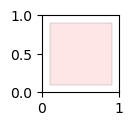

In [306]:
c = getLevelColor('bwr', 0.1)
f,ax = plt.subplots(1,1,figsize=(1,1))
square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=c)        
ax.add_patch(square)
plt.show()

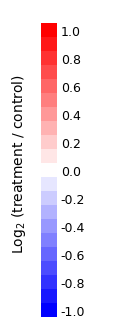

In [343]:
levels = np.linspace(-1,1,21)
ylevel = 0
f,ax = plt.subplots(figsize=(1,4))
cmap = 'bwr'
for i, level in enumerate(levels):
    square_color = getLevelColor(cmap, level)
    square = patches.Rectangle((0.1, ylevel), 0.2, 1, linewidth=0.1, edgecolor=None, facecolor=square_color)        
    ax.add_patch(square)
    tenx = int(np.round(level*10,1))
    if tenx % 2 == 0:
        ax.text(0.35,ylevel+0.15,str(np.round(level,1)),fontsize=tick_fontsize)
    ylevel += 1
ax.set_ylabel('Log$_{2}$ (treatment / control)')
ax.set_ylim([0,len(levels)+1])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
# ax.set_axis_off()
plt.show()

# Pairwise gait style comparisons

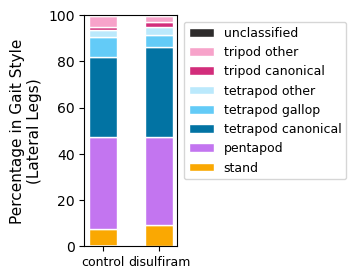

In [334]:
def gaitStylePercentagesPlot(ax, df, control='control', leg_set='lateral', addLegend=True):
    
    barWidth = 0.5
    df = df.copy()
    ylab = 'Percentage in Gait Style'

    # set up colors
    if leg_set in ['rear','two','human']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('rear')
        columns = ['% stand (rear legs)', '% step (rear legs)','% hop (rear legs)']
        ylab += '\n(Rear Legs)'
    elif leg_set in ['four','cat','dog','tetrapod']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('four')
    elif leg_set in ['lateral','insect','six']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
        columns = [x for x in gdf.columns if 'lateral' in x]
        columns = [x for x in columns if 'total' not in x]
        ylab += '\n(Lateral Legs)'
#     print(combo_colors) # test OK
#     print(columns) # test OK
    
    # set control to 0 and experimental to 1
    df['Condition'] = np.where(df['treatment'] == control, 0, 1)
    conditions = df['Condition'].values
    exp_name = np.unique(df.treatment.values[np.where(conditions==1)])[0]
#     print(exp_name)
  
    bottoms = [0,0]
    for c, column in enumerate(columns):
        data = df[column].values
        control_mean = np.mean(data[np.where(conditions==0)])
        exp_mean = np.mean(data[np.where(conditions==1)])
        for i, val in enumerate([control_mean, exp_mean]):
            if i == 0: # plot for legend
                ax.bar(i, 0, bottom = 0, color = combo_colors[all_combos[c]],
                       edgecolor='white', width=barWidth, label=all_combos[c].replace('_',' '))
            ax.bar(i, val, bottom=bottoms[i], color=combo_colors[all_combos[c]],
                  edgecolor='white',width=barWidth)
            bottoms[i] += val
    
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels([control, exp_name], fontsize=tick_fontsize)
    
    # Add a legend
    if addLegend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='upper left',
                  bbox_to_anchor=(1,1), ncol=1, fontsize=tick_fontsize)
        ax.set_ylabel(ylab, fontsize=axis_fontsize)
    ax.set_ylim([0,100])  

    return ax

df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(1.2,3))
ax = gaitStylePercentagesPlot(ax, df, 'control', 'lateral', True)
plt.show()

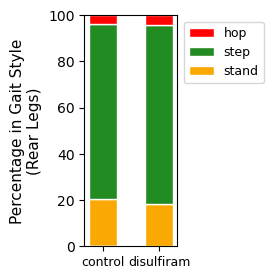

In [335]:
df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(1.2,3))
ax = gaitStylePercentagesPlot(ax, df, 'control', 'rear', True)
plt.show()